In [3]:
import pandas as pd
import numpy as np
import vertica_python
import os
import seaborn as sns

In [4]:
%matplotlib inline

In [5]:
username = os.getenv('VERTICA_USERNAME')
password = os.getenv('VERTICA_PASSWORD')
conn_info = {'host': 'warehouse.analytics.edx.org',
             'port': 5433,
             'user': username,
             'password': password,
             'database': 'warehouse',
             'read_timeout': 600,
             'unicode_error': 'strict',
             'ssl': False}

In [86]:
ltv_reg_year_query = """

SELECT
	a.fiscal_year_reg,
	a.fiscal_year_transaction,
	c.cnt_registered,
	d.cnt_enrolled_users,
	a.total_bookings,
	a.total_bookings/c.cnt_registered AS yearly_value,
	a.total_bookings/d.cnt_enrolled_users AS yearly_value_per_enrolled_users,
	a.cnt_verifications*100.0/d.cnt_enrollments AS vtr,
	a.cnt_verified_users*100.0/c.cnt_registered AS pct_verified_users,
	a.cnt_verified_users*100.0/d.cnt_enrolled_users AS pct_verified_users_who_enroll
FROM 
(
	SELECT
		CASE
			WHEN user_account_creation_time BETWEEN '2012-07-01' AND '2013-06-30' THEN 2013 
			WHEN user_account_creation_time BETWEEN '2013-07-01' AND '2014-06-30' THEN 2014 
			WHEN user_account_creation_time BETWEEN '2014-07-01' AND '2015-06-30' THEN 2015 
			WHEN user_account_creation_time BETWEEN '2015-07-01' AND '2016-06-30' THEN 2016 
			WHEN user_account_creation_time BETWEEN '2016-07-01' AND '2017-06-30' THEN 2017 
		END AS fiscal_year_reg,
		CASE
			WHEN DATE(transaction_date) BETWEEN '2013-07-01' AND '2014-06-30' THEN 2014 
			WHEN DATE(transaction_date) BETWEEN '2014-07-01' AND '2015-06-30' THEN 2015 
			WHEN DATE(transaction_date) BETWEEN '2015-07-01' AND '2016-06-30' THEN 2016 
			WHEN DATE(transaction_date) BETWEEN '2016-07-01' AND '2017-06-30' THEN 2017 
		END AS fiscal_year_transaction,
		COUNT(b.order_course_id) AS cnt_verifications,
		COUNT(DISTINCT b.order_username) AS cnt_verified_users,
		SUM(COALESCE(transaction_amount, 0)) AS total_bookings
	FROM
		production.d_user a
	LEFT JOIN
		finance.f_orderitem_transactions b
	ON
		a.user_username = b.order_username
	JOIN
    	business_intelligence.course_master e
	ON
	    b.order_course_id = e.course_id
	AND
	    e.is_wl = 0
	GROUP BY
		1,2
) a
LEFT JOIN
(
	SELECT
		CASE
			WHEN user_account_creation_time BETWEEN '2012-07-01' AND '2013-06-30' THEN 2013 
			WHEN user_account_creation_time BETWEEN '2013-07-01' AND '2014-06-30' THEN 2014 
			WHEN user_account_creation_time BETWEEN '2014-07-01' AND '2015-06-30' THEN 2015 
			WHEN user_account_creation_time BETWEEN '2015-07-01' AND '2016-06-30' THEN 2016 
			WHEN user_account_creation_time BETWEEN '2016-07-01' AND '2017-06-30' THEN 2017 
		END AS fiscal_year_reg,
		COUNT(1) AS cnt_registered
	FROM
		production.d_user
	GROUP BY 
		1
) c
ON
	a.fiscal_year_reg = c.fiscal_year_reg
LEFT JOIN
(
	SELECT
		CASE
			WHEN user_account_creation_time BETWEEN '2012-07-01' AND '2013-06-30' THEN 2013 
			WHEN user_account_creation_time BETWEEN '2013-07-01' AND '2014-06-30' THEN 2014 
			WHEN user_account_creation_time BETWEEN '2014-07-01' AND '2015-06-30' THEN 2015 
			WHEN user_account_creation_time BETWEEN '2015-07-01' AND '2016-06-30' THEN 2016 
			WHEN user_account_creation_time BETWEEN '2016-07-01' AND '2017-06-30' THEN 2017 
		END AS fiscal_year_reg,
		CASE
			WHEN first_enrollment_time BETWEEN '2013-07-01' AND '2014-06-30' THEN 2014 
			WHEN first_enrollment_time BETWEEN '2014-07-01' AND '2015-06-30' THEN 2015 
			WHEN first_enrollment_time BETWEEN '2015-07-01' AND '2016-06-30' THEN 2016 
			WHEN first_enrollment_time BETWEEN '2016-07-01' AND '2017-06-30' THEN 2017 
		END AS fiscal_year_enroll,
		COUNT(DISTINCT a.user_id) AS cnt_enrolled_users,
		COUNT(1) AS cnt_enrollments
	FROM
		production.d_user a
	LEFT JOIN
		production.d_user_course b
	ON
		a.user_id = b.user_id
	GROUP BY 
		1,2
) d
ON
	a.fiscal_year_transaction = d.fiscal_year_enroll
AND
	a.fiscal_year_reg = d.fiscal_year_reg
WHERE
	a.fiscal_year_transaction IS NOT NULL;
"""

In [87]:
connection = vertica_python.connect(**conn_info)

cur = connection.cursor('dict')

cur.execute(ltv_reg_year_query)
extract = cur.fetchall()
ltv_reg_year_df = pd.DataFrame(extract)

# cur = connection.cursor('dict')

# cur.execute(ltv_reg_year_country_query)
# extract = cur.fetchall()
# ltv_reg_year_country_df = pd.DataFrame(extract)

connection.close()

In [107]:
def prep_df(df):
    df = df[df.fiscal_year_transaction >= df.fiscal_year_reg]
    
    df['fiscal_year_reg'] = df['fiscal_year_reg'].astype('int')
    df['fiscal_year_transaction'] = df['fiscal_year_transaction'].astype('int')
    df['total_bookings'] = df['total_bookings'].astype('int')
    df['pct_verified_users'] = df['pct_verified_users'].astype('float64')
    df['pct_verified_users_who_enroll'] = df['pct_verified_users_who_enroll'].astype('float64')
    
    
    df['yearly_value'] = df['yearly_value'].astype('float64')
    df['yearly_value_per_enrolled_users'] = df['yearly_value_per_enrolled_users'].astype('float64')

#     df = df.rename(columns = {'fiscal_year_reg': 'Acquisition_Year'})
    df = df[df.fiscal_year_reg >= 2014]
    df['pct_users_enrolled'] = df.cnt_enrolled_users*100.0/df.cnt_registered
    df['year_delta'] = df['fiscal_year_transaction'] - df['fiscal_year_reg']
    
    return df

In [108]:
ltv_reg_year_df = prep_df(ltv_reg_year_df)

In [109]:
ltv_reg_year_df = ltv_reg_year_df.sort_values(by = ['fiscal_year_reg', 'year_delta'])
ltv_reg_year_df['cumulative_yearly_value'] = ltv_reg_year_df.groupby(['fiscal_year_reg']).cumsum()['yearly_value']
ltv_reg_year_df['yearly_value_per_enrolled_users'] = ltv_reg_year_df.groupby(['fiscal_year_reg']).cumsum()['yearly_value']

In [110]:
gradient_palette = sns.light_palette("teal", 4)
sns.set_style("darkgrid")
sns.set_context("poster", font_scale=1.5, rc={"lines.linewidth": 4})

In [111]:
plot_list = ['yearly_value', 'yearly_value_per_enrolled_users', 'pct_users_enrolled', 'cumulative_yearly_value']
plot_list_short = ['yearly_value', 'yearly_value_per_enrolled_users']

In [112]:
def make_plots(df, is_country=False):
    if (is_country):
        for i in df.user_last_location_country_code.unique():
            
            temp_df = df[df.user_last_location_country_code == i]
            
            for j in plot_list:
                ax = sns.factorplot(
                    data = temp_df,
                    x = 'year_delta',
                    y = j,
                    hue = 'fiscal_year_reg',
                    kind = 'point',
                    size = 10,
                    palette = gradient_palette
                )
                ax.set(title = '%s vs Years from Reg FY, Country = %s' % (j,i),
                      xlabel = 'Years from Acquisition',
                      ylabel = j)       
                
            ax = sns.factorplot(
                data = temp_df[(temp_df.fiscal_year_reg == temp_df.fiscal_year_transaction)],
                x = 'fiscal_year_reg',
                y = 'yearly_value',
                kind = 'bar',
                size = 10,
                palette = gradient_palette
            )
            ax.set(title = 'First Year Value of New Users, by Reg FY, Country = %s' % i,
                  xlabel = 'Year',
                  ylabel = 'Yearly Value per User')
            
    else:
        for j in plot_list:
            ax = sns.factorplot(
                data = df,
                x = 'year_delta',
                y = j,
                hue = 'fiscal_year_reg',
                kind = 'point',
                size = 10,
                palette = gradient_palette
            )
            ax.set(title = '%s vs Years from Reg FY' % j,
                  xlabel = 'Years from Acquisition',
                  ylabel = j)
        
        ax = sns.factorplot(
            data = ltv_reg_year_df[ltv_reg_year_df.fiscal_year_reg == ltv_reg_year_df.fiscal_year_transaction],
            x = 'fiscal_year_reg',
            y = 'yearly_value',
            kind = 'bar',
            size = 10,
            palette = gradient_palette
        )
        ax.set(title = 'First Year Value of New Users, by Reg FY',
              xlabel = 'Year',
              ylabel = 'Yearly Value per User')

## Overall

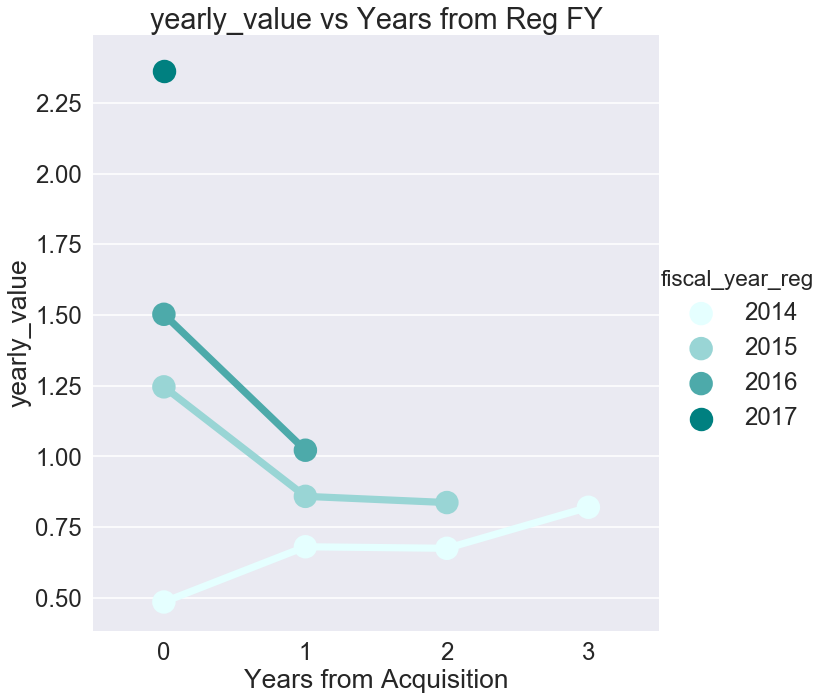

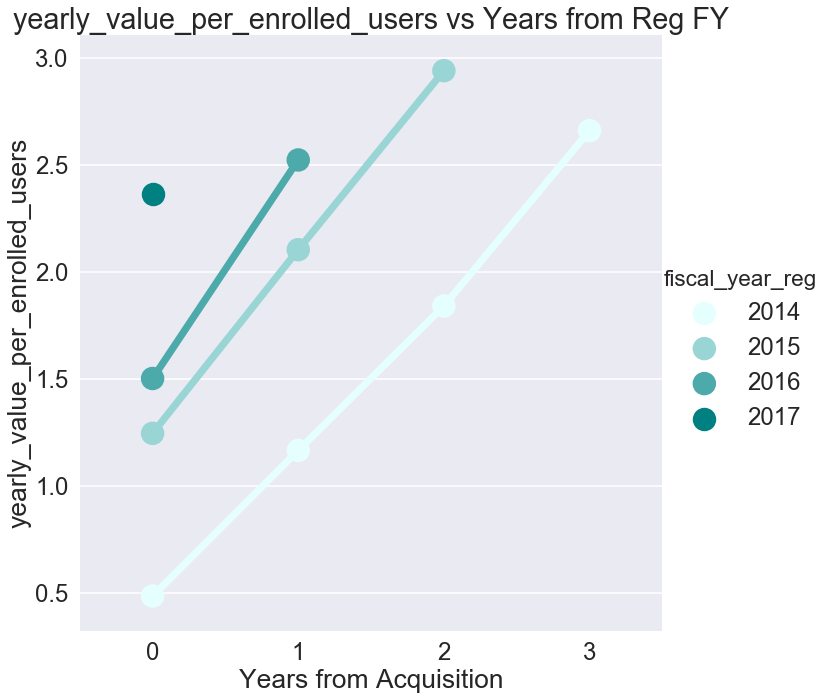

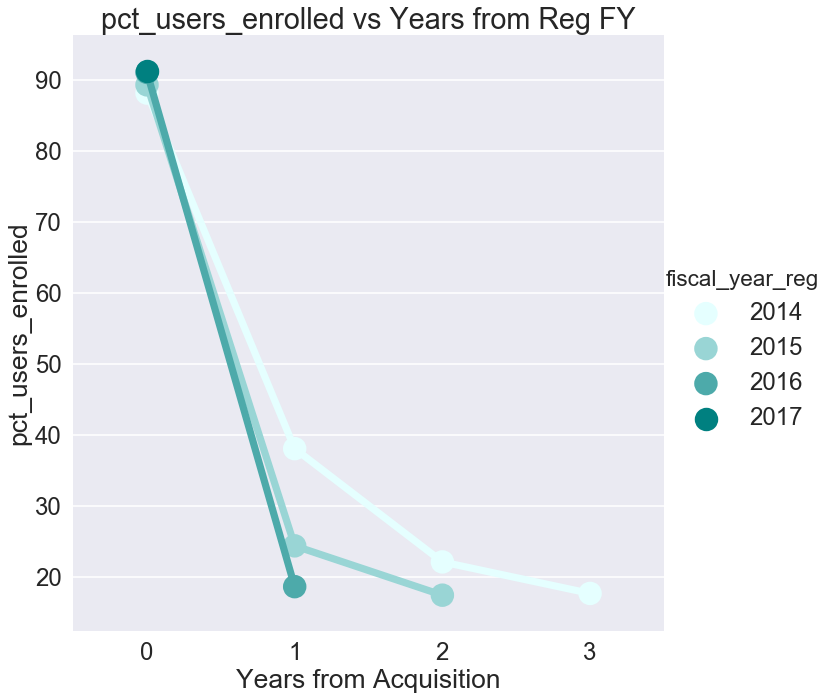

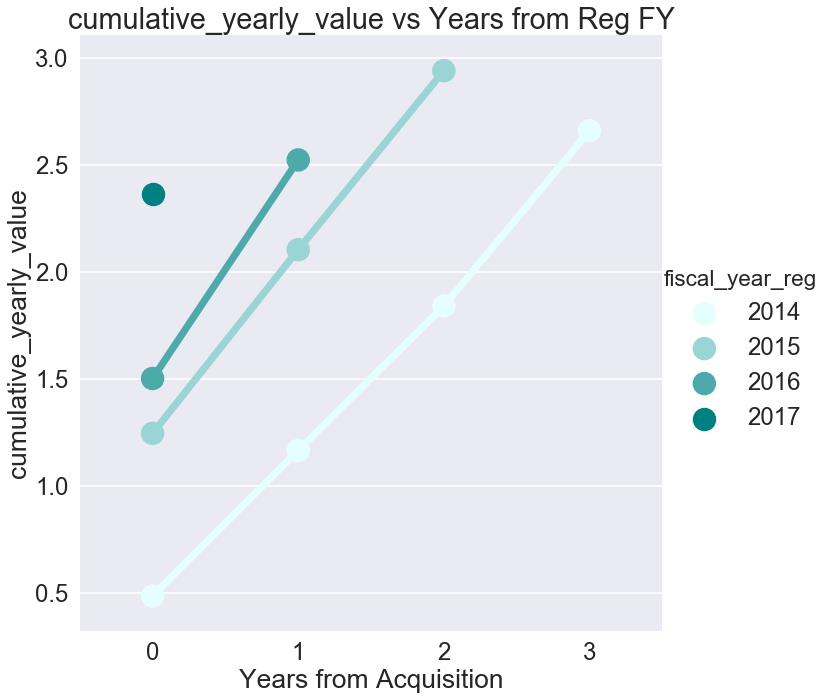

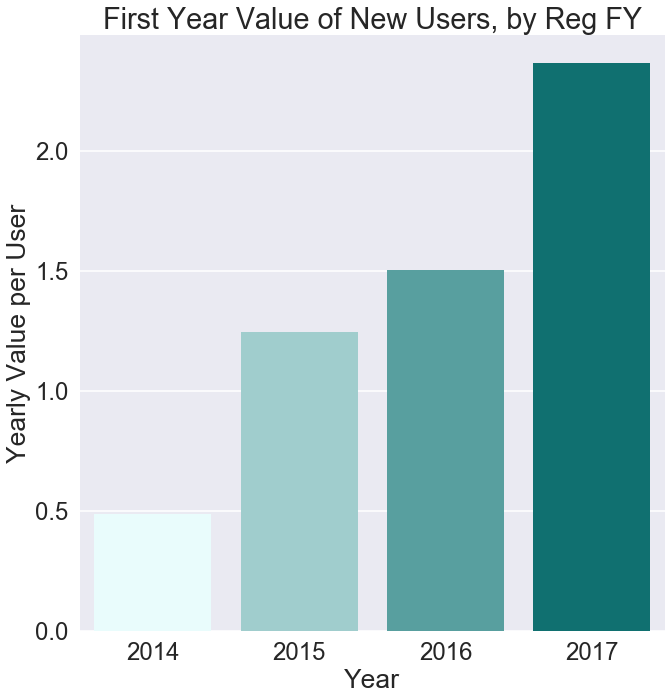

In [113]:
make_plots(ltv_reg_year_df)

In [114]:
ltv_reg_year_df = ltv_reg_year_df.reset_index()

ltv_reg_year_combined_df = ltv_reg_year_df.set_index('fiscal_year_transaction').join(
    ltv_reg_year_df.groupby('fiscal_year_transaction').sum()['total_bookings'].reset_index().set_index('fiscal_year_transaction'),
    #on = 'fiscal_year_transaction',
    how = 'inner',
    rsuffix = '_total'
)
ltv_reg_year_combined_df = ltv_reg_year_combined_df.reset_index()

In [115]:
ltv_reg_year_combined_df['pct_fiscal_year_bookings'] = ltv_reg_year_combined_df.total_bookings*100.0/ltv_reg_year_combined_df.total_bookings_total

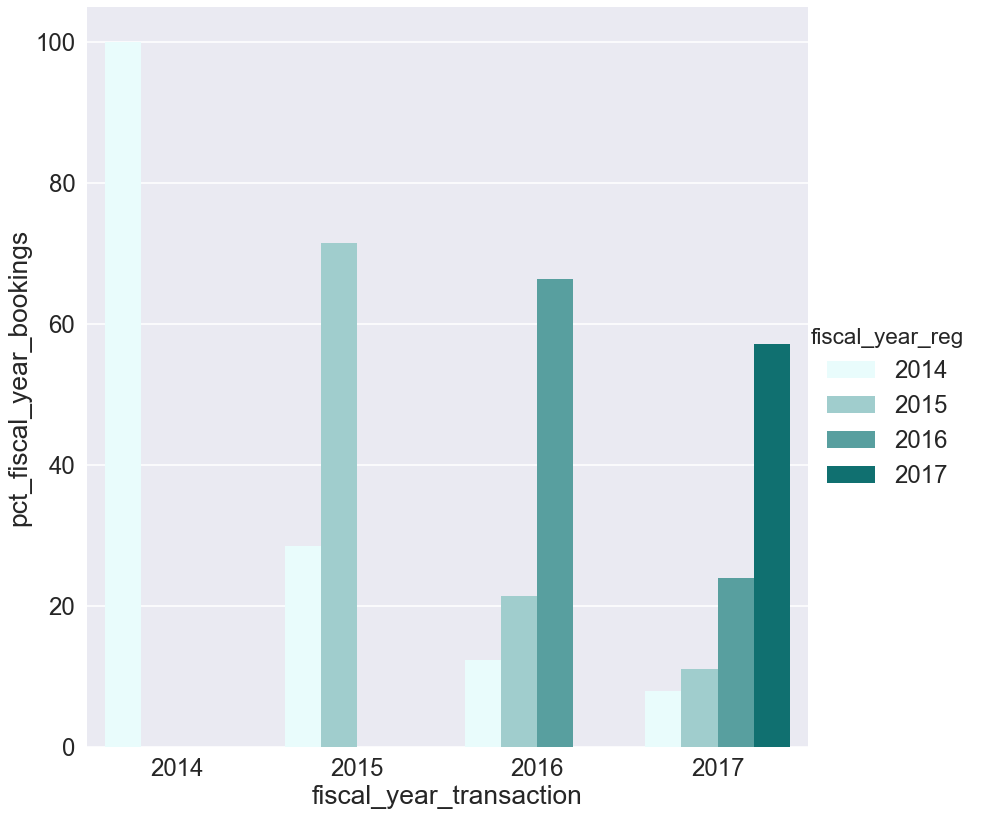

In [116]:
sns.factorplot(
    data = ltv_reg_year_combined_df,
    x = 'fiscal_year_transaction',
    y = 'pct_fiscal_year_bookings',
    hue = 'fiscal_year_reg',
    kind = 'bar',
    size = 12,
    palette = gradient_palette
    
    
)

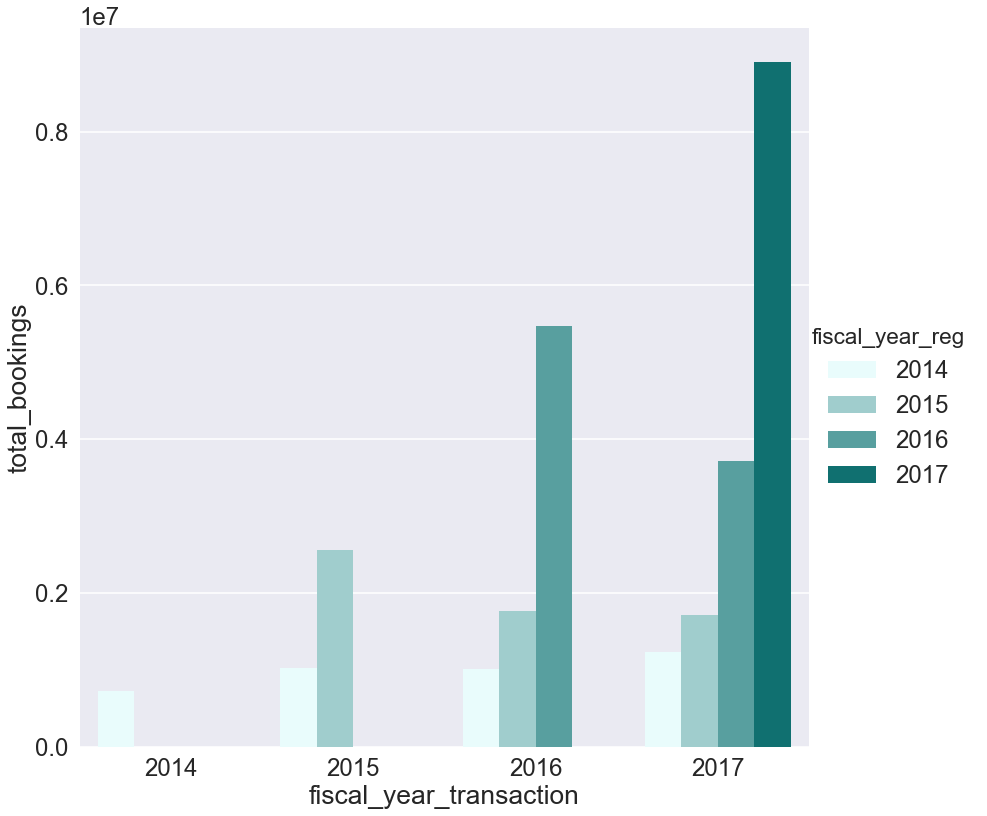

In [117]:
sns.factorplot(
    data = ltv_reg_year_combined_df,
    x = 'fiscal_year_transaction',
    y = 'total_bookings',
    hue = 'fiscal_year_reg',
    kind = 'bar',
    size = 12,
    palette = gradient_palette
)

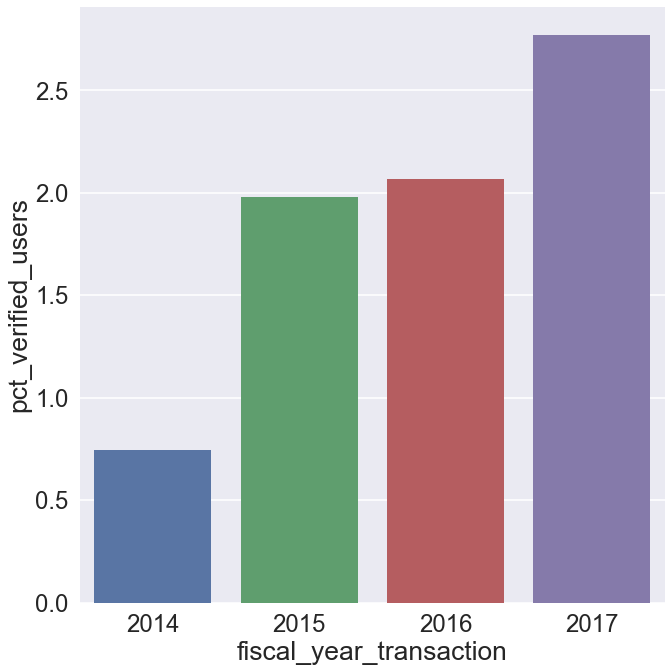

In [118]:
sns.factorplot(
    data = ltv_reg_year_combined_df[ltv_reg_year_combined_df.fiscal_year_transaction == ltv_reg_year_combined_df.fiscal_year_reg],
    x = 'fiscal_year_transaction',
    y = 'pct_verified_users',
    kind = 'bar',
    size = 10,
    
)

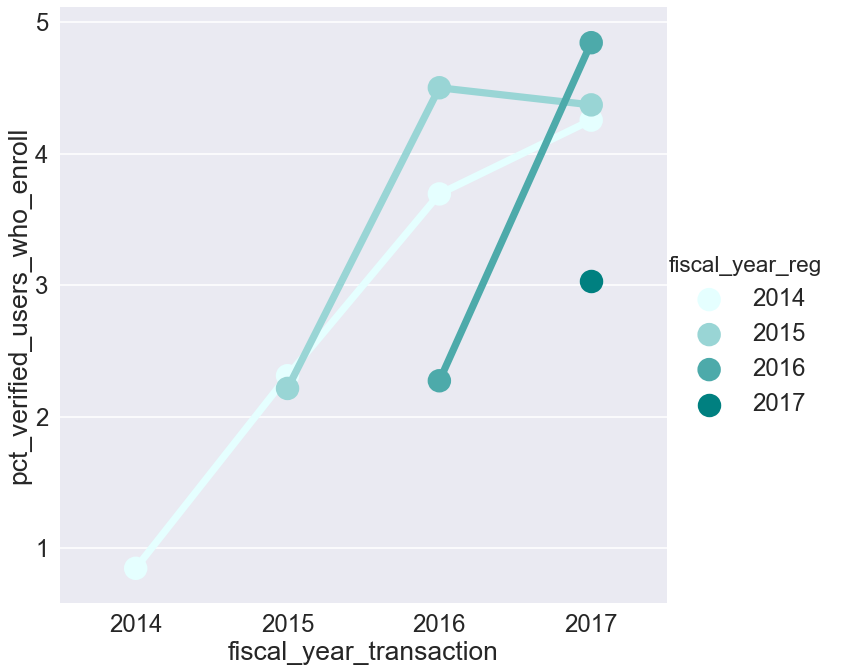

In [121]:
sns.factorplot(
    data = ltv_reg_year_combined_df,
    x = 'fiscal_year_transaction',
    y = 'pct_verified_users_who_enroll',
    kind = 'point',
    size = 10,
    hue = 'fiscal_year_reg',
    palette = gradient_palette
)